In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability as tfp

1. Define a sample scenario

In [10]:
# for example, let's take a sample sequence of spend prior
channel_names = ['TV', 'Display', 'Video']
spend = np.array([17626593.,  6211104.,  6556994.])
viewability = np.array([0.98, 0.76, 0.33])
working_spend = spend * viewability


2. Prior distribution for the Media Coefficient

In [11]:
# step 1 - get the sigma to the half-normal distribution
cf_prior_sigma = np.round(working_spend / np.max(working_spend), 2)  # note: this used to be the sigma to the half-normal distribution
print(f"Sigma to the half-nomal distribution: {cf_prior_sigma}")


Sigma to the half-nomal distribution: [1.   0.27 0.13]


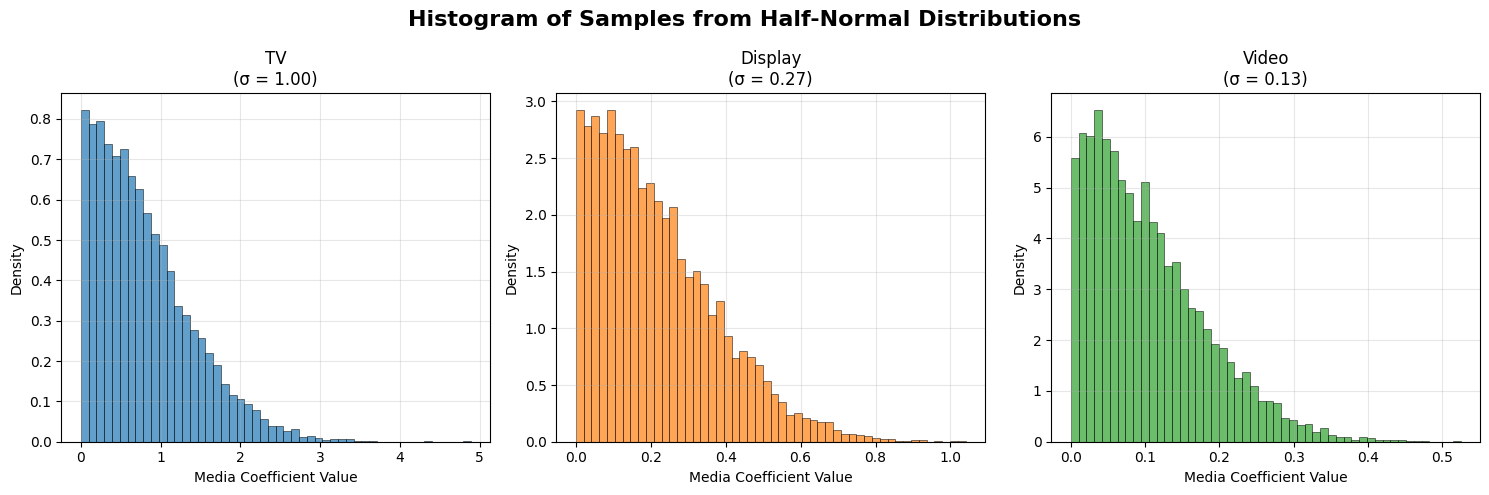

Half-normal distribution samples generated and plotted for each channel


In [32]:
# Step 2 - Sample from half-normal distribution for each channel
n_samples = 10000

# Create half-normal distributions for each channel
half_normal_samples = {}
for i, channel in enumerate(channel_names):
    # Create half-normal distribution with the calculated sigma
    half_normal_dist = tfp.distributions.HalfNormal(scale=cf_prior_sigma[i])
    # Sample from the distribution
    samples = half_normal_dist.sample(n_samples)
    half_normal_samples[channel] = samples.numpy()

# Plot histograms of the samples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Histogram of Samples from Half-Normal Distributions', fontsize=16, fontweight='bold')

for i, channel in enumerate(channel_names):
    ax = axes[i]

    # Plot histogram of samples
    ax.hist(half_normal_samples[channel], bins=50, density=True, alpha=0.7,
            color=f'C{i}', edgecolor='black', linewidth=0.5)

    # Customize plot
    ax.set_title(f'{channel}\n(σ = {cf_prior_sigma[i]:.2f})')
    ax.set_xlabel('Media Coefficient Value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Half-normal distribution samples generated and plotted for each channel")

3. Changes for the geo model

- geo level coefficients are sampled as exp(beta_m + eta_gm) where beta_m is hierarchical mean, and eta_m is deviation from mean (i.e., std-dev)
- since beta_m is inferred in log-space, we would need to convert our half-normal into equivalent log-normal distribution
- also, we need to define the prior distribution for the eta_m

3.1 Half-Normal to Log-Normal

In [53]:
# Step 3.1 - Sample from hierarhical mean
geometric_std = np.log(1 + .1)
mu = np.log(0.8 * cf_prior_sigma) - (geometric_std ** 2 / 2)  # half-normal mean to log-normal mean
geometric_std = np.full_like(mu, geometric_std)  # log-normal std-dev
print(f"mu in log: {mu}")
print(f"geometric_std: {geometric_std}")


mu in log: [-0.22768557 -1.53701889 -2.2679064 ]
geometric_std: [0.09531018 0.09531018 0.09531018]


In [46]:
print(f"half normal mean : {cf_prior_sigma * 0.8}")
print(f"log normal mean : {mu}")
print(f"log normal mean (exponentiated): {np.exp(mu)}")

half normal mean : [0.8   0.216 0.104]
log normal mean : [-0.22768557 -1.53701889 -2.2679064 ]
log normal mean (exponentiated): [0.79637463 0.21502115 0.1035287 ]


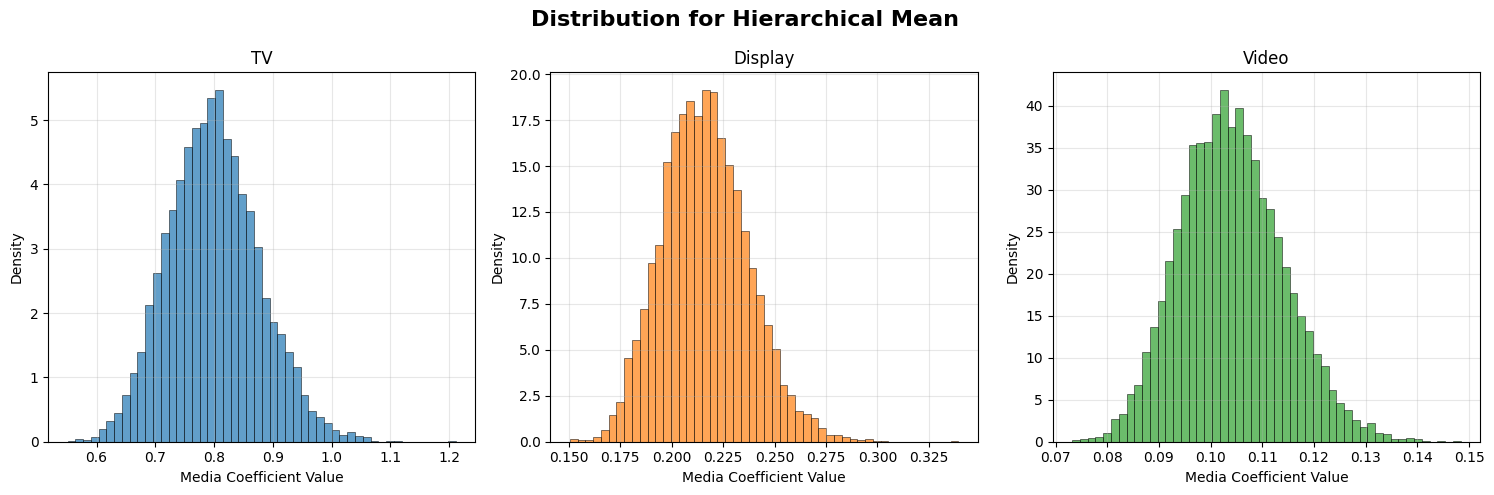

Half-normal distribution samples generated and plotted for each channel


In [ ]:

n_samples = 10000

# Create half-normal distributions for each channel
log_normal_exponentiated_samples = {}
for i, channel in enumerate(channel_names):
    # Create half-normal distribution with the calculated sigma
    log_normal_dist = tfp.distributions.Normal(loc=mu[i], scale=geometric_std[i])
    # Sample from the distribution
    samples = log_normal_dist.sample(n_samples)
    log_normal_exponentiated_samples[channel] = np.exp(samples.numpy())

# Plot histograms of the samples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distribution for Hierarchical Mean', fontsize=16, fontweight='bold')

for i, channel in enumerate(channel_names):
    ax = axes[i]

    # Plot histogram of samples
    ax.hist(log_normal_exponentiated_samples[channel], bins=50, density=True, alpha=0.7,
            color=f'C{i}', edgecolor='black', linewidth=0.5)

    # Customize plot
    ax.set_title(f'{channel}')
    ax.set_xlabel('Media Coefficient Value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Half-normal distribution samples generated and plotted for each channel")

3.2 Geo level deviations

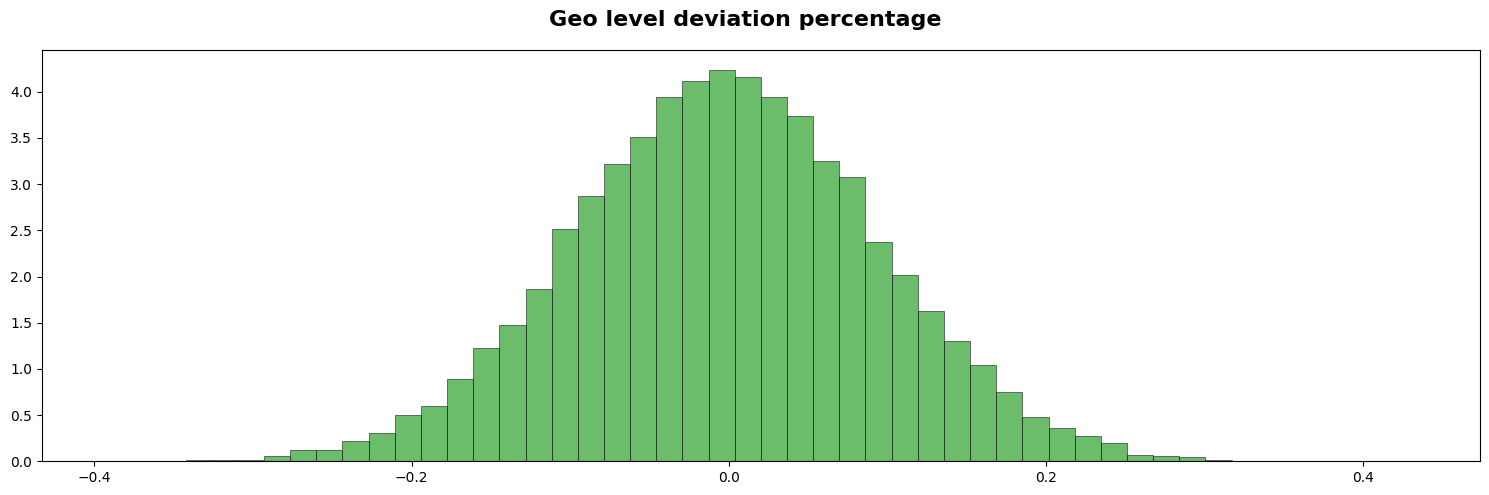

In [52]:
# a. eta_m prior (std-dev for the hierarchical distribution)
eta_m_mu = 0.0
eta_m_sigma = np.log(1 + .1)

# Step 2 - Sample from half-normal distribution for each channel
n_samples = 10000
dist_obj = tfp.distributions.Normal(loc=eta_m_mu, scale=eta_m_sigma)
samples = dist_obj.sample(n_samples).numpy()

# Plot histograms of the samples
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('Geo level deviation percentage', fontsize=16, fontweight='bold')

# Plot histogram of samples
ax.hist(samples, bins=50, density=True, alpha=0.7,
        color=f'C{i}', edgecolor='black', linewidth=0.5)

plt.tight_layout()
plt.show()


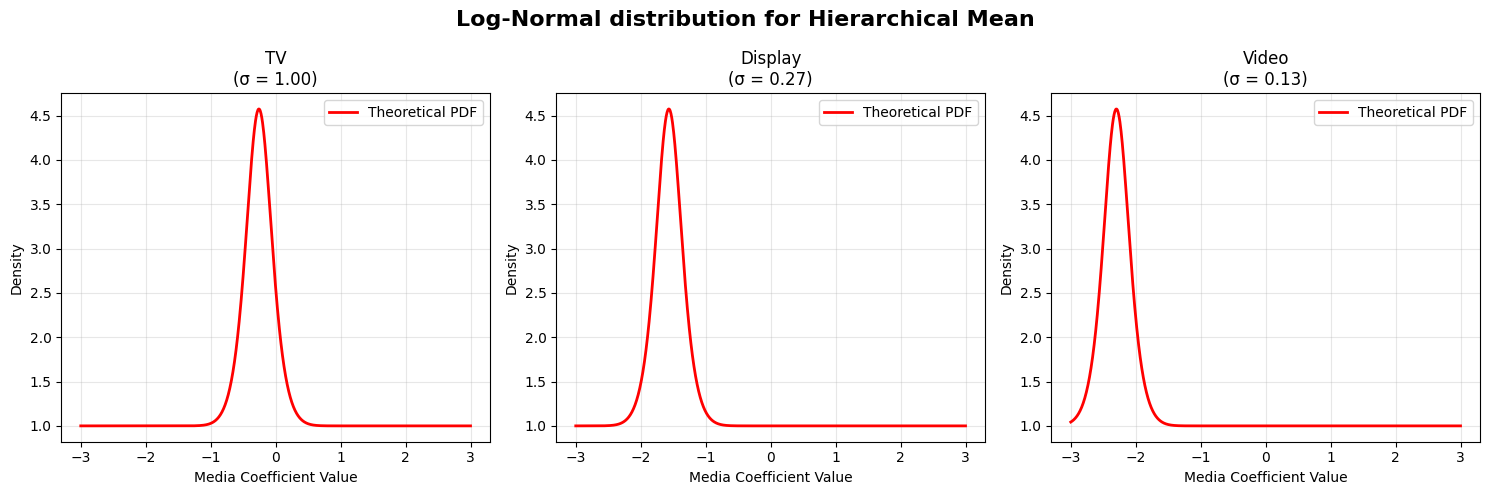

In [29]:
geometric_std = np.log(1 + 0.1)
mu = np.log(0.8 * cf_prior_sigma) - (geometric_std ** 2 / 2)  # half-normal mean to log-normal mean
geometric_std = np.full_like(mu, geometric_std)  # log-normal std-dev


# Step 4 - Plot the equivalent log-normal distributions for each channel
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Log-Normal distribution for Hierarchical Mean', fontsize=16, fontweight='bold')

for i, channel in enumerate(channel_names):
    ax = axes[i]

    # Plot theoretical PDF only
    x_range = np.linspace(-3, 3, 1000)
    normal_dist = tfp.distributions.Normal(loc=mu[i], scale=geometric_std[i])
    theoretical_pdf = np.exp(normal_dist.prob(x_range).numpy())
    ax.plot(x_range, theoretical_pdf, 'r-', linewidth=2, label='Theoretical PDF')

    # Customize plot
    ax.set_title(f'{channel}\n(σ = {cf_prior_sigma[i]:.2f})')
    ax.set_xlabel('Media Coefficient Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
np.exp(theoretical_pdf)

/var/folders/yc/q3l7zfz56nqcr4r6q26n67rm0000gp/T/ipykernel_12235/2597478216.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(theoretical_pdf)


array([2.71828183e+000, 2.71828183e+000, 2.71828183e+000, 2.71828183e+000,
       2.71828183e+000, 2.71828183e+000, 2.71828183e+000, 2.71828183e+000,
       2.71828183e+000, 2.71828183e+000, 2.71828183e+000, 2.71828183e+000,
       2.71828183e+000, 2.71828183e+000, 2.71828183e+000, 2.71828183e+000,
       2.71828183e+000, 2.71828183e+000, 2.71828183e+000, 2.71828183e+000,
       2.71828183e+000, 2.71828183e+000, 2.71828183e+000, 2.71828183e+000,
       2.71828183e+000, 2.71828183e+000, 2.71828183e+000, 2.71828185e+000,
       2.71828203e+000, 2.71828380e+000, 2.71829732e+000, 2.71838273e+000,
       2.71883491e+000, 2.72087132e+000, 2.72878471e+000, 2.75578265e+000,
       2.83888285e+000, 3.08194424e+000, 3.83573396e+000, 7.06536390e+000,
       5.44077199e+001, 1.01730341e+006, 1.28695490e+043,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,  